# Team BNP: Black Litterman, Mean Variance Optimization and Backtest

Renjie Pan (renjie.pan@nyu.edu)

Tianyu Zhang (tianyuzhang@nyu.edu)

Liang Zou (liazou@nyu.edu)

In [1]:
import numpy as np
import pandas as pd
import cvxopt as opt 
import matplotlib.pyplot as plt
from cvxopt import blas, solvers, matrix
solvers.options['show_progress'] = False
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
original_return = pd.read_excel('Return Data.xlsx', 0, header=[0, 1])
return_data = original_return.copy()
return_data.columns = return_data.columns.get_level_values(0)
return_data = return_data.rename(columns = {'Unnamed: 0_level_0': 'Date'})
return_data = return_data.sort_values(by = 'Date')
return_data = return_data.set_index('Date')
return_data.index = return_data.index.to_period('M')

# drop CRB Metals Index
return_data = return_data.drop(['CRB Metals'], axis=1)
# return_data

In [3]:
sign_1m = return_data.rolling(2).apply(lambda x: x[-1] / x[0] - 1, 'raw=True').iloc[1:]
sign_3m = return_data.rolling(4).apply(lambda x: x[-1] / x[0] - 1, 'raw=True').iloc[3:]

In [4]:
sign_3m.head()

,MSCI EM,SPX 500 Price Return,Eurostoxx 600,MSCI Japan,MSCI World,Russell 2000,Crude Oil Total Return,Gold Price,S&P GSCI Total Return Index,UST 7-10yr,German 7-10yr,US IG Corps,US HY Corp,US Mortgages
Date,,,,,,,,,,,,,,
1988-03,0.206400,0.102490,0.069902,0.245134,0.110885,0.184455,0.055203,-0.056083,0.066419,0.019031,0.014186,0.019608,0.025914,0.013384
1988-04,0.153994,0.048303,0.090139,0.141346,0.098152,0.161790,0.092719,-0.019651,0.071004,-0.031057,-0.002798,-0.027451,0.001238,-0.014221
1988-05,0.181802,-0.007749,0.045063,0.009737,0.017133,0.037365,0.115621,0.068872,0.121219,-0.057627,-0.027763,-0.051741,-0.022358,-0.032553
1988-06,0.108339,0.018818,0.077297,-0.002353,-0.014099,0.061468,-0.101555,-0.044644,0.037587,-0.013009,-0.026163,-0.014536,-0.000221,-0.012929
1988-07,0.028906,0.024752,0.067907,0.019543,-0.008032,0.027830,-0.097929,-0.027171,0.012351,-0.015930,-0.024770,-0.005957,0.006839,-0.011358


## Create Views (P, Q, $\Omega$)

In [5]:
def generate_views(pred, covar, IC=0.2, BR=12):
    """
    Generate views (P, Q, O) for black litterman based on model predictions
    @param pred: numpy array (model predictions of all asset classes)
    @param covar: numpy array (covariance matrix of all asset classes)
    @param IC: float (information coefficient)
    @param BR: Strategy's Breadth
    @return:
        Q: vector of K views
        P: matrix of trades associated with views (KxN)
        O: diagonal matrix of uncertainty associated the the trades (KxK)
    """
    P = np.diag(pred)
    # print(P.dot(covar).dot(P.T))
    O = np.diag(np.diag(P.dot(covar).dot(P.T)))
    vol = np.sqrt(np.diag(covar))
    Q = (vol.T * IC * np.sqrt(BR)).reshape(-1, 1)
    
    # print([P.shape, Q.shape, O.shape])
    # print([len(P), len(Q), len(O)])

    return P, Q, O

## Use Black Litterman to compute posterior expected returns and covariance

$$\mu_{BL} = \pi + \Sigma P^T (P\Sigma P^T + \frac{\Omega}{\tau})^{-1} (q - P \pi)$$

$$\Sigma_{BL} = (1+\tau) \Sigma - \tau^2 \Sigma P^T (\tau P \Sigma P^T + \Omega)^{-1} P \Sigma$$

In [6]:
def black_litterman(pi, S, Q, P, O, t=0.025):
    """
    Updates prior views with manager views
    
    Inputs:
       pi is our prior expected returns
       S is our prior covariance matrix
       Q is our vector of K views
       P is our matrix of trades associated with views (KxN)
       O is a diagonal matrix of uncertainty associated the the trades (KxK)
       t is the tau parameter (float)
    
    Outputs:
       Posterior Pi - Pi updated for views
       Posterior S - S updated for views
    """

    """assert(type(pi) == pd.Series)
    assert(type(S) == pd.DataFrame)
    assert(type(Q) == pd.Series)
    assert(type(P) == pd.DataFrame)
    assert(type(O) == pd.DataFrame)"""

    tickers = pi.index
    # print(tickers)

    k = len(Q)
    n = len(pi)

    assert(P.shape[0] == k)
    assert(P.shape[1] == n)

    assert(O.shape[0] == k)
    assert(O.shape[1] == k)

    pi = pi.values.T
    S = S.values
    """Q = Q.values
    P = P.values
    O = O.values"""
    
    ts = t * S

    M = np.linalg.inv(ts) + np.dot(P.T, np.linalg.solve(O, P))

    posteriorPi = np.linalg.solve(M, (np.linalg.solve(ts, pi) + np.dot(P.T, np.linalg.solve(O, Q))))
    posteriorS = S + np.linalg.inv(M)
    print(posteriorPi.flatten().shape)

    posteriorPi = pd.Series(posteriorPi.flatten(), index = tickers)
    posteriorS = pd.DataFrame(posteriorS, index = tickers, columns = tickers)
   
    return [posteriorPi, posteriorS]

def black_litterman_2009(pi, S, Q, P, O, tau=0.025):
    """
    Compute posterior expected returns and variance using BL formula
    Inputs:
       pi is our prior expected returns
       S is our prior covariance matrix
       Q is our vector of K views
       P is our matrix of trades associated with views (KxN)
       O is a diagonal matrix of uncertainty associated the the trades (KxK)
       t is the tau parameter (float)
    
    Outputs:
       Posterior Pi - Pi updated for views
       Posterior S - S updated for views
    """
    
    tickers = pi.index
    pi = pi.values.reshape(-1,1)
    S = S.values
    
    posteriorPi = pi + S.dot(P.T).dot(np.linalg.inv(P.dot(S).dot(P.T) + O/tau)).dot(Q - P.dot(pi))
    posteriorS = (1 + tau) * S - tau * tau * S.dot(P.T).dot(np.linalg.inv(tau * P.dot(S).dot(P.T) + O)).dot(P).dot(S)
    
    posteriorPi = pd.Series(posteriorPi.flatten(), index = tickers)
    posteriorS = pd.DataFrame(posteriorS, index = tickers, columns = tickers)
    
    return [posteriorPi, posteriorS]

## Risk Parity to Construct Portfolio Weights

In [7]:
from scipy.optimize import minimize
TOLERANCE = 1e-10

def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error

    
def _get_risk_parity_weights(covariances, assets_risk_budget=None, initial_weights=None):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    
    assets_risk_budget = [1 / covariances.shape[1]] * covariances.shape[1]
    initial_weights = [1 / covariances.shape[1]] * covariances.shape[1]
    
    # print(assets_risk_budget)
    # print(initial_weights)
    
    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights.reshape(-1, 1)

In [8]:
covariances = 12 * return_data.cov().values

# The desired contribution of each asset to the portfolio risk: we want all
# asset to contribute equally
assets_risk_budget = [1 / covariances.shape[1]] * covariances.shape[1]

# Initial weights: equally weighted
init_weights = [1 / covariances.shape[1]] * covariances.shape[1]

# Optimisation process of weights
weights = _get_risk_parity_weights(covariances, assets_risk_budget, init_weights)

# Convert the weights to a pandas Series
weights

array([[0.0771311 ],
       [0.07724149],
       [0.07703012],
       [0.07588051],
       [0.07746626],
       [0.07855824],
       [0.06229843],
       [0.07807519],
       [0.01522225],
       [0.07630607],
       [0.07640445],
       [0.07615385],
       [0.07606012],
       [0.07617193]])

## Construct Optimal Portfolio

$$\max_{w} w^T \mu - \frac{\delta}{2} w^T \Sigma w $$

$$s.t. w^T \textbf{1} = 1$$

In [9]:
def optimal_portfolio(returns, covariance):
    """
    Compute optimal portfolio using convex optimization
    @param returns: numpy array (mean returns)
    @param covariance: numpy array (covariance matrix)
    @return: numpy array (portfolio weights)
    """
    n = len(returns)  
    returns = np.asmatrix(returns)  
    returns = returns.T
    N = 100  
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 
    
    # Convert to cvxopt matrices  
    S = opt.matrix(covariance)  
    pbar = opt.matrix(returns)  
    
    # Create constraint matrices  
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix  
    h = opt.matrix(0.0, (n ,1))  
    A = opt.matrix(1.0, (1, n))  
    b = opt.matrix(1.0)  
    
    # Calculate efficient frontier weights using quadratic programming  
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    # CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]  
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]  
    
    # CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)  
    x1 = np.sqrt(m1[2] / m1[0])  
    
    # CALCULATE THE OPTIMAL PORTFOLIO  
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']  
    
    return np.asarray(wt)

In [10]:
prediction = pd.Series(np.array([1,-1,1,-1,-1,1,1,-1,-1,-1,-1,1,1,-1]))
# cov_matrix = np.array([[2,0],[0, 1]])
exp_return1 = return_data.mean()
cov_return1 = return_data.cov()
P1, Q1, O1 = generate_views(prediction, sign_1m.cov())

post_exp1, post_cov1 = black_litterman_2009(exp_return1, cov_return1, Q1, P1, O1)
optimal_portfolio(post_exp1.values, post_cov1.values)

array([[-8.85918849e-11],
       [-2.93942371e-11],
       [-1.40468050e-11],
       [ 1.28683032e-02],
       [-8.13000243e-11],
       [-1.01329284e-10],
       [ 2.19868920e-09],
       [-1.03761241e-10],
       [-1.47486732e-10],
       [ 3.09036567e-10],
       [ 6.64139472e-10],
       [ 1.36461267e-09],
       [ 2.57370294e-01],
       [ 7.29761399e-01]])

## Backtest

Compare the performance of following portfolio:
- Black Litterman (BL)
- Mean Variance Optimization (MVO)
- Equal Weights (EW)
- Risk Parity (RP)

In [48]:
portfolios = ['Black Litterman', 'Mean Variance', 'Equal Weight', 'Risk Parity',
               'Mean Variance (ML)', 'Equal Weight (ML)', 'Risk Parity (ML)']
    
def compute_PnL(pred_return, true_return, factor=12, start_capital=1e6, step_size=1, window_size=60):
    """
    Compute PnL based on forecast and true returns
    @param pred_return: numpy array (predicted return)
    @param true_return: numpy array (true return)
    @param factor: integer (annualized factor: transform monthly returns to annual returns)
    @param start_capital: float (number of capitals at the beginning)
    @param step_size: integer (how frequent to construct portfolio)
    @param window_size: integer (window size must be greater than number of asset classes)
    @return: two Pandas Series (PnL for Black Litterman and Mean Variance Optimization)
    """
    PnL_df = {p: [start_capital] for p in portfolios}
    
    start_index = pred_return.index[0] if pred_return.index[0] > true_return.index[0] else true_return.index[0]
    end_index = pred_return.index[-1] if pred_return.index[-1] < true_return.index[-1] else true_return.index[-1]
    
    time = start_index + window_size - 1
    start_index -= 1
    # time_index = true_return.loc[start_index + window_size - 1:end_index,:].index
    # print(true_return.loc[start_index + window_size:end_index,:].index)
    time_index = [time - step_size]
    # print([start_index, time, true_return.loc[start_index:time,:]])
    
    while time <= end_index:
        # for time in range(start_index + window_size, end_index):
        # Compute annualized returns
        pred_t = pred_return.loc[start_index:time,:]
        true_t = true_return.loc[start_index:time,:] * factor
        
        # print(pred_t.index)
        # print(true_t.index)
        # print([pred_t.shape, true_t.shape])
        
        # Compute expected returns and covariance matrix up to time t
        exp_return = true_t.mean(axis=0)
        cov_return = true_t.cov()
        
        # print(cov_return.values)
        # print(np.linalg.inv(cov_return.values))
        
        # Compute accuracy of prediction for information coefficient
        accuracy = (np.sum((pred_t * true_t).applymap(lambda x: x > 0)) / true_t.size).values
        # print(accuracy)
        
        # Genearate views
        P, Q, O = generate_views(pred_return.loc[time,:].values, cov_return.values, IC=(2 * accuracy - 1))
        #P, Q, O = generate_views(pred_return.loc[time,:].values, cov_return.values, IC=0.1)
        # print(P)
        # print(Q)
        # print(O)
        
        # print([O.shape, P.shape])
        # print(np.diag(P.dot(cov_return).dot(P.T)))
        # print([np.linalg.inv(cov_return)])
        # print(np.dot(P.T, np.linalg.solve(O, P)))
        
        # Compute posterior expected returns and covariance
        post_exp, post_cov = black_litterman_2009(exp_return, cov_return, Q, P, O)
        
        # print([time, np.linalg.det(np.diag(1 / np.diag(post_cov.values)).dot(post_cov.values))])

        # Compute Optimal weights and PnL for BL
        try:
            weight_BL = optimal_portfolio(post_exp.values, post_cov.values)
        except:
            # if posterior covariance matrix is not full rank (which cannot find optimal weight for BL)
            # use original mean variance optimization for weight instead
            # weight_BL = optimal_portfolio(post_exp.values, cov_return.values)
            print([time, start_index])
            weight_BL = optimal_portfolio(exp_return.values, cov_return.values)

        # print(weight_BL.T.dot(true_return.loc[time,:].values.reshape(-1,1)))
        port_return_BL = weight_BL.T.dot(true_return.loc[time,:].values.reshape(-1,1)).item() # * factor / 12
        
        PnL_df['Black Litterman'].append(PnL_df['Black Litterman'][-1])
        PnL_df['Black Litterman'][-1] *= (1 + port_return_BL)
        
        # Compute Optimal weights and PnL for MVO
        weight_MVO = optimal_portfolio(exp_return.values, cov_return.values)
        port_return_MVO = weight_MVO.T.dot(true_return.loc[time,:].values.reshape(-1,1)).item() # * factor / 12
        
        PnL_df['Mean Variance'].append(PnL_df['Mean Variance'][-1])
        PnL_df['Mean Variance'][-1] *= (1 + port_return_MVO)
        
        # Compute PnL for Equal Weight
        port_return_EW = np.mean(true_return.loc[time,:].values).item() # * factor / 12
        
        PnL_df['Equal Weight'].append(PnL_df['Equal Weight'][-1])
        PnL_df['Equal Weight'][-1] *= (1 + port_return_EW)
        
        # Compute Optimal weights and PnL for RP
        weight_RP = _get_risk_parity_weights(cov_return.values)
        port_return_RP = weight_RP.T.dot(true_return.loc[time,:].values.reshape(-1,1)).item() # * factor / 12
        
        PnL_df['Risk Parity'].append(PnL_df['Risk Parity'][-1])
        PnL_df['Risk Parity'][-1] *= (1 + port_return_RP)
        
        # Find the asset with positive predictions based on machine learning
        asset_positive = true_return.columns[np.where(pred_return.loc[time,:].values == 1)]
        # print([time, len(asset_positive)])
        
        if len(asset_positive) < 2:
            # if less than 2 assets have positive returns, keep the current capital
            PnL_df['Mean Variance (ML)'].append(PnL_df['Mean Variance (ML)'][-1])
            PnL_df['Equal Weight (ML)'].append(PnL_df['Equal Weight (ML)'][-1])
            PnL_df['Risk Parity (ML)'].append(PnL_df['Risk Parity (ML)'][-1])

        elif len(asset_positive) == 2 and np.linalg.det(true_t[asset_positive].corr()) < 0.1:
            # if there are only two asset classes but with high correlations (i.e. small determinants)
            # keep the current capital, otherwise optimization will explode
            PnL_df['Mean Variance (ML)'].append(PnL_df['Mean Variance (ML)'][-1])
            PnL_df['Equal Weight (ML)'].append(PnL_df['Equal Weight (ML)'][-1])
            PnL_df['Risk Parity (ML)'].append(PnL_df['Risk Parity (ML)'][-1])

        else:
            exp_return_ml = true_t[asset_positive].mean(axis=0)
            cov_return_ml = true_t[asset_positive].cov()
            
            # if len(asset_positive) == 2:
            # print([time, len(asset_positive), asset_positive, np.linalg.det(true_t[asset_positive].corr())])
        
            # Compute Optimal weights and PnL for MVO
            weight_MVO = optimal_portfolio(exp_return_ml.values, cov_return_ml.values)
            port_return_MVO = weight_MVO.T.dot(true_return.loc[time,asset_positive].values.reshape(-1,1)).item() 
                              # * factor / 12
            
            PnL_df['Mean Variance (ML)'].append(PnL_df['Mean Variance (ML)'][-1])
            PnL_df['Mean Variance (ML)'][-1] *= (1 + port_return_MVO)

            # Compute PnL for Equal Weight
            port_return_EW = np.mean(true_return.loc[time,asset_positive].values).item() # * factor / 12
            
            PnL_df['Equal Weight (ML)'].append(PnL_df['Equal Weight (ML)'][-1])
            PnL_df['Equal Weight (ML)'][-1] *= (1 + port_return_EW)

            # Compute Optimal weights and PnL for RP
            weight_RP = _get_risk_parity_weights(cov_return_ml.values)
            port_return_RP = weight_RP.T.dot(true_return.loc[time,asset_positive].values.reshape(-1,1)).item() 
                              # * factor / 12
            
            PnL_df['Risk Parity (ML)'].append(PnL_df['Risk Parity (ML)'][-1])
            PnL_df['Risk Parity (ML)'][-1] *= (1 + port_return_RP)
        
        time_index.append(time)
        time += step_size
        start_index += step_size
    
    PnL_df = pd.DataFrame(PnL_df, index = time_index)
    
    return PnL_df

In [49]:
pred_1m = pd.read_csv('pred_1month.csv', index_col='Date')
pred_1m.index = pd.to_datetime(pred_1m.index).to_period('M')
pred_1m = pred_1m.drop(['CRB Metals'], axis=1)

In [50]:
PnL_1m = compute_PnL(pred_1m, sign_1m)

In [51]:
pred_3m = pd.read_csv('pred_3month.csv', index_col='Date')
pred_3m.index = pd.to_datetime(pred_3m.index).to_period('M')
pred_3m = pred_3m.drop(['CRB Metals'], axis=1)

In [52]:
# posterior covariance matrix is not full rank (cannot find solution for BL)

# sign_3m.iloc[175-60:175].cov()

exp_return_175 = sign_3m.iloc[175-60:175].mean() * 4
cov_return_175 = sign_3m.iloc[175-60:175].cov() * 16

P_175, Q_175, O_175 = generate_views(pred_3m.iloc[175,:].values, sign_3m.iloc[175-60:175].cov().values)
post_exp_175, post_cov_175 = black_litterman_2009(exp_return_175, cov_return_175, Q_175, P_175, O_175)

# np.linalg.det(sign_3m.iloc[175-60:175].cov() * 4 * 4)
# optimal_portfolio(post_exp_175.values, post_cov_175.values)

In [53]:
PnL_3m = compute_PnL(pred_3m, sign_3m, factor=4, step_size=3)

In [54]:
sign_1m_pred = sign_1m.applymap(lambda x: 1 if x > 0 else -1)
sign_3m_pred = sign_3m.applymap(lambda x: 1 if x > 0 else -1)

# PnL_1m = compute_PnL(sign_1m_pred, sign_1m)
# PnL_3m = compute_PnL(sign_3m_pred, sign_3m)

In [55]:
PnL_3m.tail()

,Black Litterman,Mean Variance,Equal Weight,Risk Parity,Mean Variance (ML),Equal Weight (ML),Risk Parity (ML)
2018-08,3.701676e+07,1.994325e+07,2.923799e+06,1.982316e+06,2.211614e+07,3.415723e+06,2.110716e+06
2018-11,3.527345e+07,1.900402e+07,2.746761e+06,1.930525e+06,2.107457e+07,3.192031e+06,2.051033e+06
2019-02,3.560103e+07,1.922475e+07,2.835990e+06,1.968381e+06,2.131935e+07,3.308025e+06,2.090772e+06
2019-05,3.653322e+07,1.992155e+07,2.803958e+06,1.991979e+06,2.209207e+07,3.232686e+06,2.077684e+06
2019-08,3.781140e+07,2.012581e+07,2.775628e+06,1.974564e+06,2.231858e+07,3.240099e+06,2.044497e+06


## Visualize Result

In [56]:
def draw_PnL(PnLs):
    """
    Draw PnL to compare Black Litterman and Mean Variance Optimization
    @param PnLs: list of Pandas Series (PnL of different portfolios)
    """
    plt.figure(figsize=(20,10))
    plt.rc('font', size=20)
    index = PnLs.index.to_timestamp()
    
    # print(index)
    for model in PnLs.columns:
        plt.plot(index, PnLs[model])
    
    # plt.xticks(index)
    plt.legend(PnLs.columns)
    plt.title('Comparison of Capital among different portfolios')
    plt.ylabel('Capital')

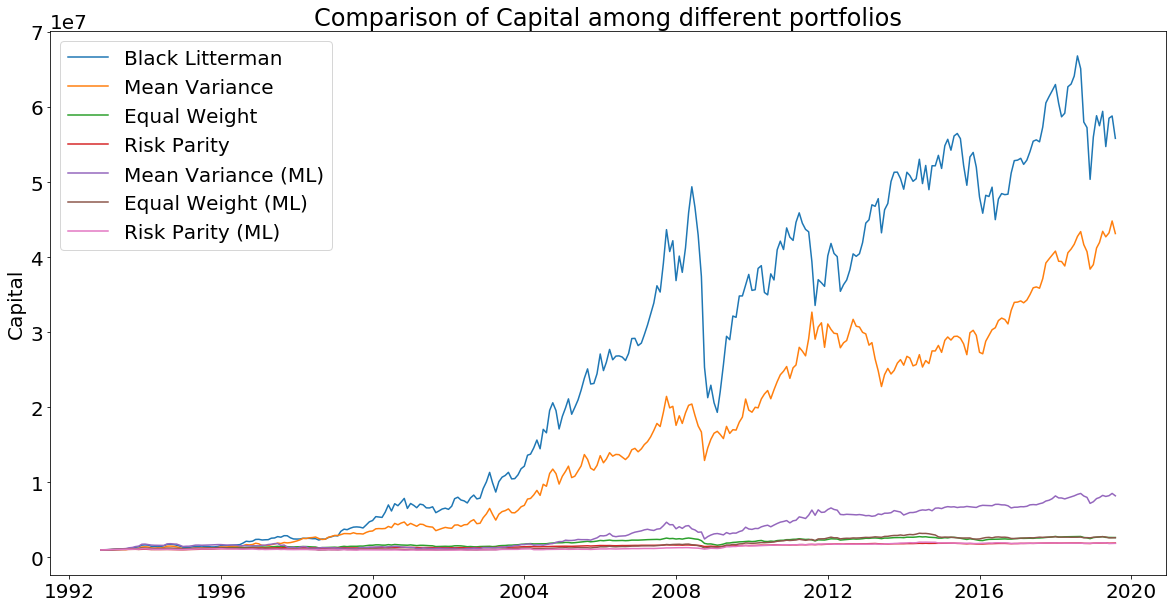

In [57]:
draw_PnL(PnL_1m)

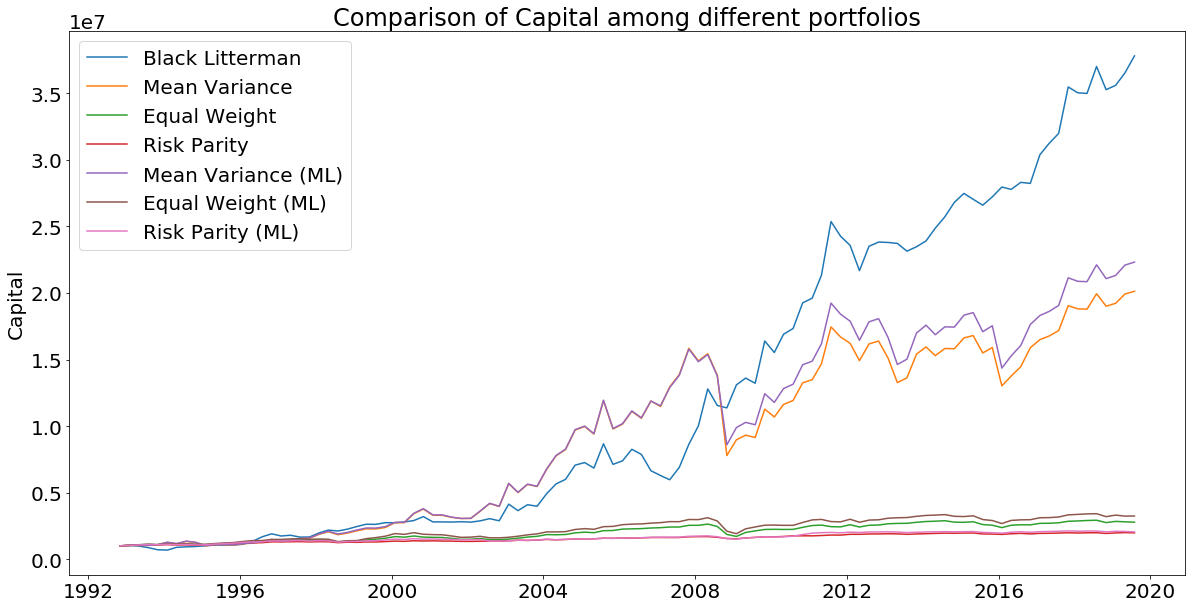

In [58]:
draw_PnL(PnL_3m)

## Summary Statistic (Sharpe Ratio, Max Drawdown)

In [59]:
def sharpe_ratio(series, factor=12):
    """
    Compute the Sharpe Ratio given time series
    @param series: Pandas Series
    @param factor: integer (annaulized factor)
    @return: float (Sharpe Ratio)
    """
    series_return = series.pct_change().dropna()
    sharpe = round(series_return.mean() / series_return.std(), 4)
    return sharpe * factor

def max_drawdown(series):
    """
    Compute the maximal drawdown given time series
    @param series: Pandas Series
    @return: float (maximal drawdown)
    """
    series_return = series.pct_change().dropna() + 1
    # print(series_return)
    
    max_prod = series_return[0]
    min_prod = series_return[0]
    
    # max_index = 0
    # min_index = len(series_return) - 1

    for i in range(len(series_return)):
        if series_return[i] > max_prod:
            max_prod = series_return[i]
            # max_index = i
        if min_prod > series_return[i] / max_prod:
            # print([start, end, max_index, min_index])
            min_prod = series_return[i] / max_prod
            # min_index = i
    
    drawdown = round(min_prod - 1, 4)
    return drawdown

def annualized_return(series, factor=12):
    """
    Compute Annualized Return given time series
    @param series: Pandas Series
    @param factor: integer (annaulized factor)
    @return: float (Annualized Return)
    """
    series_return = series.pct_change().dropna()
    mean_return = round(series_return.mean(), 4)
    return mean_return * factor
    
def compute_summary_stats(PnLs, factor=12):
    '''
    Compute summary statistics (Sharpe Ratio and Max Drawdown) for every time series
    @param PnLs: list of Pandas Series (PnL of different portfolios)
    @param factor: integer (annaulized factor)
    @return: Pandas DataFrame (summary table)
    '''
    summary = {'Sharpe Ratio': [], 'Max Drawdown(%)': [], 'Annualized Return(%)': []}
    
    for model in PnLs.columns:
        # Compute Annualized Sharpe Ratio
        summary['Sharpe Ratio'].append(sharpe_ratio(PnLs[model], factor))
        # Compute Max Drawdown
        summary['Max Drawdown(%)'].append(max_drawdown(PnLs[model]) * 100)
        # Compute Annualized Return
        summary['Annualized Return(%)'].append(annualized_return(PnLs[model], factor) * 100)
    
    summary = pd.DataFrame(summary)
    summary.index = PnLs.columns
    
    return summary

In [60]:
compute_summary_stats(PnL_1m)

,Sharpe Ratio,Max Drawdown(%),Annualized Return(%)
Black Litterman,2.6724,-44.13,17.88
Mean Variance,2.8068,-34.48,16.08
Equal Weight,1.6224,-21.21,4.08
Risk Parity,2.1168,-9.66,2.52
Mean Variance (ML),1.9464,-37.74,9.24
Equal Weight (ML),1.5636,-19.54,4.08
Risk Parity (ML),1.5396,-12.82,2.52


In [61]:
compute_summary_stats(PnL_3m, factor=4)

,Sharpe Ratio,Max Drawdown(%),Annualized Return(%)
Black Litterman,1.5324,-42.71,15.76
Mean Variance,1.2540,-60.74,13.84
Equal Weight,0.9028,-29.77,4.32
Risk Parity,1.3596,-9.90,2.64
Mean Variance (ML),1.3064,-56.53,14.08
Equal Weight (ML),0.9228,-34.13,5.04
Risk Parity (ML),1.0700,-13.38,2.84
